# 日志分析与可视化分析
# Simulation Run Log Analysis and Visualization for AWS DeepRacer

##### 代码来源于DeepRacer Community ( code source from DeepRacer Community): 
- https://github.com/aws-deepracer-community/aws-deepracer-workshops/blob/master/log-analysis/

##### 本笔记本介绍如何使用 AWS DeepRacer 模拟日志进行分析和调试
1. 查找模型最佳迭代的工具
1. 可视化赛道上的奖励分配
 - 可视化每个回合或迭代的奖励热图
1. 为您的模型识别赛道上的热点
1. 了解模拟图像上的概率分布
1. 评估运行分析 - 绘制圈速热图

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap

## 要求/Requirements
boto3 >= 1.9.133; 配置 aws-cli 和/或 aws python sdk boto3 的密钥 

boto 3>= 1.9.133; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

### IAM 权限/IAM permissions
为执行该笔记本的SageMaker notebook分配一个可以访问DeepRacer服务权限的角色。通常策略里包含”deepracer:*"权限。

Assign your Sagemaker notebook an execution role with permission to access the deepracer service. Typically this is done by providing "deepracer:*" permissions.

In [1]:
# 导入可能使用到的python 库
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
%matplotlib inline
from os import listdir
from os.path import isfile, join

# 安装shapeley
!pip install shapely

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

from log_analysis import *
from os import listdir
from os.path import isfile, join

# Ignore deprecation warnings we have no power over
# 忽略我们无法控制的弃用警告，让输出更干净一些
import warnings
warnings.filterwarnings('ignore')

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


## 训练任务是在AWS DeepRacer管理控制台运行的，通过提供模型名称，下载模型和日志
Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name


In [2]:
# 设置模型名称，改成你的模型
# Change to your model
model_name="22-April-Open-4m3-30d7-DitchCover-progress-speed-steps-clone" 

# 如果你想分析评估（Evaluation）阶段的日志，设置成 False
# Make this False if you want to do log analysis on Evaluation.
is_training = True  

# 清理之前的临时文件或上次分析时下载的旧数据
# Clean useless files before download new data
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model

envroot = os.getcwd()
aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

region = "us-east-1"
dr_client = boto3.client('deepracer', region_name=region,
        endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))
models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
for model in models:
    if model["ModelName"]==model_name:
        break
ModelArn=model["ModelArn"]

In [3]:
# 根据任务需要，获取训练日志或评估日志
if is_training:
    training_job=dr_client.list_training_jobs(ModelArn=ModelArn,MaxResults=100)["TrainingJobs"][0]
    training_log_url= dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(training_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)
else:       
    evaluation_job = dr_client.list_evaluations(ModelArn=ModelArn,MaxResults=100)["EvaluationJobs"][0]
    evaluation_log_url= dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']

    with requests.get(evaluation_log_url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)
                
# 获取模型ID
ModelUuid=ModelArn[ModelArn.rfind('/')+1:]
simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(ModelUuid)
if not is_training:
    simtrace_path = "./downloaded_model/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(ModelUuid)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

# 创建目录，并删除临时文件
!mkdir -p downloaded_model/{ModelUuid}
!mkdir -p intermediate_checkpoint/{ModelUuid}/model-artifacts

!tar -xf {model_name}.tar.gz -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include=*.csv --exclude=* {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}
!rm -rf {model_name}.tar.gz

# 下载模型文件，并解压
model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="COMPLETE_MODEL_ARTIFACT")['Url']
    
with requests.get(model_url, stream=True) as response:
    with open("{}-model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar zxvf {model_name}-model.tar.gz -C intermediate_checkpoint/ \*.csv {ModelUuid}/model/* {ModelUuid}/metrics/*
!rm -rf {model_name}-model.tar.gz

model_url= dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="MODEL_ARTIFACT")['Url']

with requests.get(model_url, stream=True) as response:
    with open("{}-model-artifacts.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar zxvf {model_name}-model-artifacts.tar.gz -C intermediate_checkpoint/{ModelUuid}/model-artifacts
!rm -rf {model_name}-model-artifacts.tar.gz

f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/metrics/evaluation/evaluation-20220602112550-QSwaVe6WR2SeEPPAJ6exPw.json
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/metrics/evaluation/evaluation-20220607053639-PO7SFu-uTyGiR6ECFols4g.json
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/metrics/training/training-20220602064924-CGHCyZl9T1-sJuliYthRLA.json
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/245_Step-2931.ckpt.data-00000-of-00001
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/245_Step-2931.ckpt.index
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/245_Step-2931.ckpt.meta
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_245.pb
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_246.pb
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_247.pb
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_248.pb
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_metadata.json
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/sim-trace/evaluation/20220602112550-QSwaVe6WR2SeEPPAJ6exPw/evaluation-simtrace/0-iteration.csv
f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/s

查看此次训练的元数据，包括：行动空间，传感器类型，神经网络，训练算法，行动空间类别。

In [4]:
with open("intermediate_checkpoint/{}/model/model_metadata.json".format(ModelUuid),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': [{'steering_angle': -30, 'speed': 2.5, 'index': 0},
  {'steering_angle': -15, 'speed': 3.3, 'index': 1},
  {'steering_angle': -5, 'speed': 4, 'index': 2},
  {'steering_angle': -20, 'speed': 2.5, 'index': 3},
  {'steering_angle': -20, 'speed': 4, 'index': 4},
  {'steering_angle': -8, 'speed': 4, 'index': 5},
  {'steering_angle': -10, 'speed': 2.5, 'index': 6},
  {'steering_angle': -10, 'speed': 4, 'index': 7},
  {'steering_angle': -3, 'speed': 4, 'index': 8},
  {'steering_angle': 0, 'speed': 4, 'index': 9},
  {'steering_angle': 0, 'speed': 4, 'index': 10},
  {'steering_angle': 0, 'speed': 4, 'index': 11},
  {'steering_angle': 10, 'speed': 2.5, 'index': 12},
  {'steering_angle': 10, 'speed': 3.3, 'index': 13},
  {'steering_angle': 3, 'speed': 4, 'index': 14},
  {'steering_angle': 20, 'speed': 2.5, 'index': 15},
  {'steering_angle': 20, 'speed': 3.3, 'index': 16},
  {'steering_angle': 8, 'speed': 3.3, 'index': 17},
  {'steering_angle': 30, 'speed': 2.5, 'index': 18},
  {'

### 下载日志

- 根据仿真ID下载所需的日志文件 Download the desired log file given the simulation ID
- 合并所有的csv文件到一个大的csv文件 Merge all the csv files into one big .csv file

In [5]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]

# 将所有的日志合并至一个文件
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    line = re.sub(r'(\[[^\]]*\])', r'"\1"', line, flags=re.M)
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

79,250.0,-2.360833692399907,-1.8525021347103436,-23.06929755832865,0.0,4.0,11,2.328782981079783,False,True,99.444964774645,159,50.300488720486186,1103.152,in_progress,0.0
79,251.0,-2.202736081572897,-1.9163864060257194,-22.434655059578088,0.0,4.0,11,2.328173880753681,False,True,99.78159096100292,159,50.300488720486186,1103.219,in_progress,0.0
79,252.0,-1.957167037626624,-2.0140894046049853,-21.826339169519283,-5.0,4.0,2,2.326396825396825,True,True,100,160,50.300488720486186,1103.286,lap_complete,0.0


### 辅助的画图函数 Helper Functions

In [6]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=3, c='red')
    for i,p in enumerate(points):
        if i%10 ==0:
            ax.annotate(i, (p[0], p[1]))

def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='lightgray', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='white', zorder=1)                               
                                                                                
def plot_line(ax, ob, color='green'):                                                          
    x, y = ob.xy
    ax.plot(x, y, alpha=0.7, color=color, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_line(ax, line, color='lightgreen')                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)

# 画出完成赛道最快的n圈
# plot top n completed laps
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
    return fig

## 设定需要分析的赛道名称，加载赛道文件

In [7]:
#选择赛道
TRACK_NAME = '2022_april_open'

#导入赛道路点
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

#导入最佳行车线，最佳速度图，此行车线是由计算机辅助创建的
fpath = f'./racelines/optimals_newest_{TRACK_NAME}.npy'
raceline = np.load(fpath)

### 查看日志信息

In [8]:
EPISODE_PER_ITER = 20 if is_training else 1

df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
0,0,1.0,0.125920,-3.420376,-28.767815,-5.0,4.0,2,0.000000,False,True,0.278633,0,50.300489,22.949,prepare,0.0,1
1,0,2.0,0.125790,-3.420294,-28.765531,-5.0,4.0,2,0.348909,False,True,0.278327,0,50.300489,23.020,in_progress,0.0,1
2,0,3.0,0.135528,-3.423290,-28.318839,-30.0,2.5,0,0.249471,False,True,0.298166,0,50.300489,23.086,in_progress,0.0,1
3,0,4.0,0.149786,-3.440805,-30.304268,-5.0,4.0,2,0.213356,False,True,0.339769,1,50.300489,23.150,in_progress,0.0,1
4,0,5.0,0.173128,-3.463964,-32.094661,0.0,4.0,9,0.202303,False,True,0.402605,1,50.300489,23.218,in_progress,0.0,1


### 画出跑得最快的几个回合

In [9]:
# 定义画图函数
def plot_top_laps_to_raceline(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        #line = LineString(center_line)
        #plot_coords(ax, line)
        #plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        #plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        #plot_line(ax, line)
        
        x1=[i[0] for i in episode_data]
        y1=[i[1] for i in episode_data]
        speed=[i[5] for i in episode_data]
        #for idx in range(1, len(episode_data)-1):
        #    x1,y1,action,reward,angle,speed = episode_data[idx]
        #    car_x2, car_y2 = x1 - 0.02, y1
        #for idx in range(1, len(racing_track)-1):
        #    plt.plot(racing_track[idx][0],racing_track[idx][1],hue=racing_track[idx][2], palette="vlag")
        sns.scatterplot(x=x1, y=y1, hue=speed, palette="Greens")
        
        # optimal raceline
        x1=[i[0] for i in raceline]
        y1=[i[1] for i in raceline]
        speed=[i[2] for i in raceline]
        sns.scatterplot(x=x1, y=y1, hue=speed, palette="Reds")
       
    plt.show()
    return fig


跑得最快的三个回合是： [57, 58, 36]


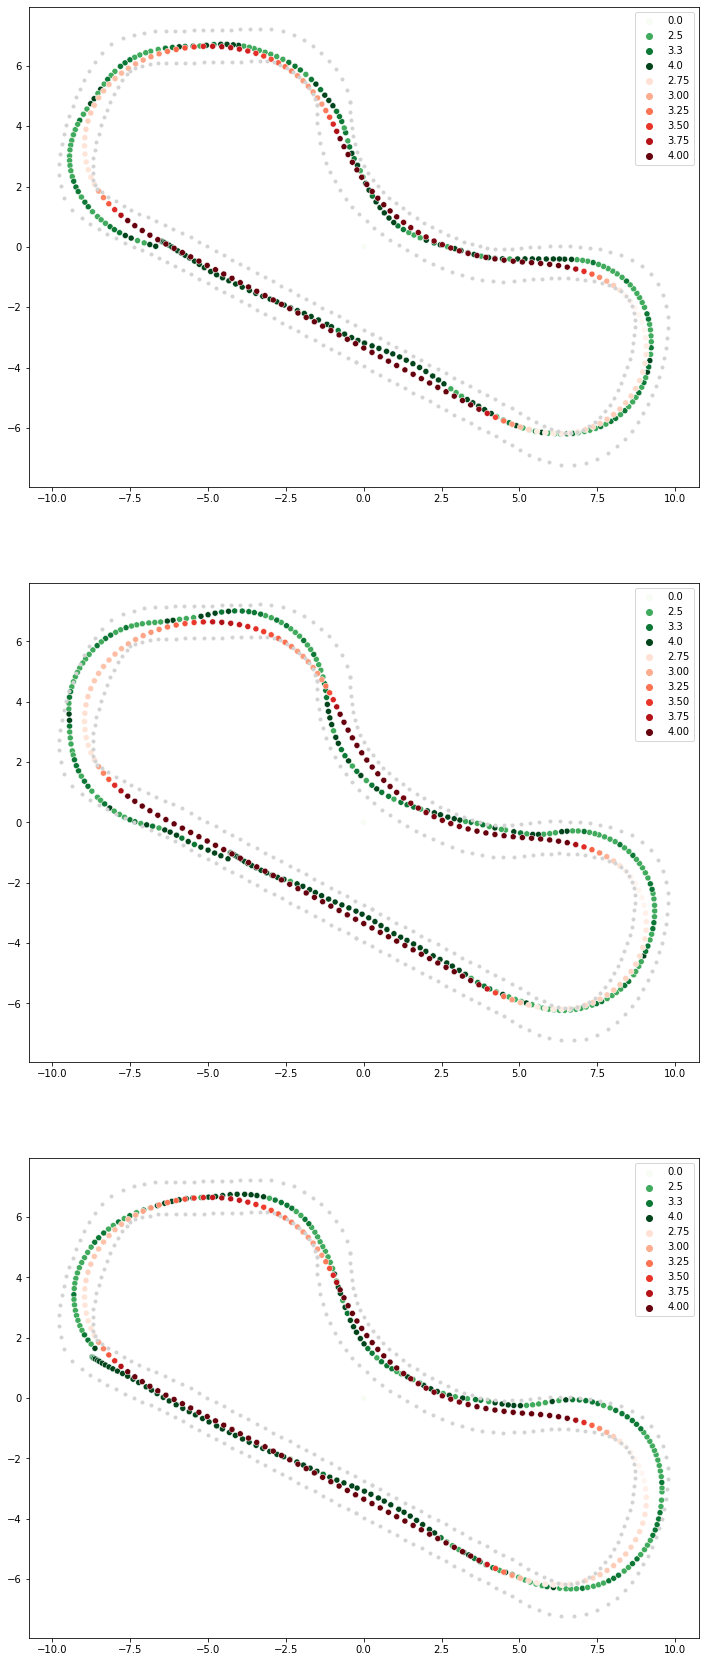

In [10]:
# 赛车实际跑的路线默认使用绿色表示，红色是计算机辅助创建的最佳行车线（需要先创建行车线才可以展示）
action_map, episode_map, sorted_idx = episode_parser(df)
print("跑得最快的三个回合是： {}".format(sorted_idx[:3]))
#print("The top 3 highest reward episodes are: {}".format(sorted_idx[:3]))
fig = plot_top_laps_to_raceline(sorted_idx[:], 3)

### 画出每个回合赛车的行车线

In [11]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    plt.axis('equal')
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

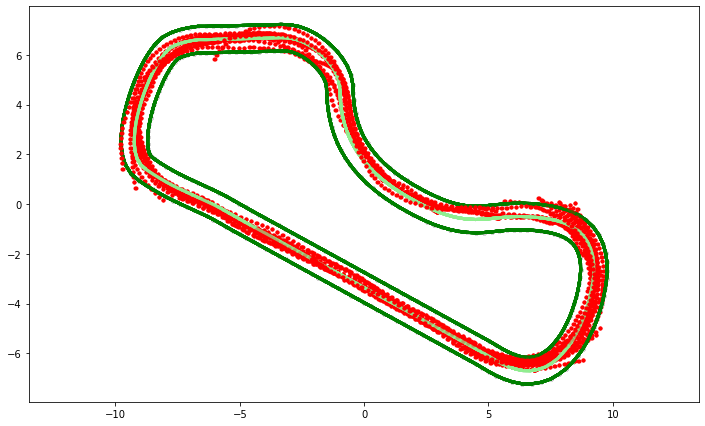

In [12]:
#iteration_id = 1

for iteration_id in range(1,2):#max(df["iteration"]+1)) :
    for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
        plot_episode_run(df, E=i)

### 画出完成赛道的行车线

In [13]:
## Evaluation Completed Laps
def plot_episode_complete(df):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    plt.axis('equal')
    print_border(ax, center_line, inner_border, outer_border) 
    for row in df.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2],'r.')
        

Total completed laps are: 33


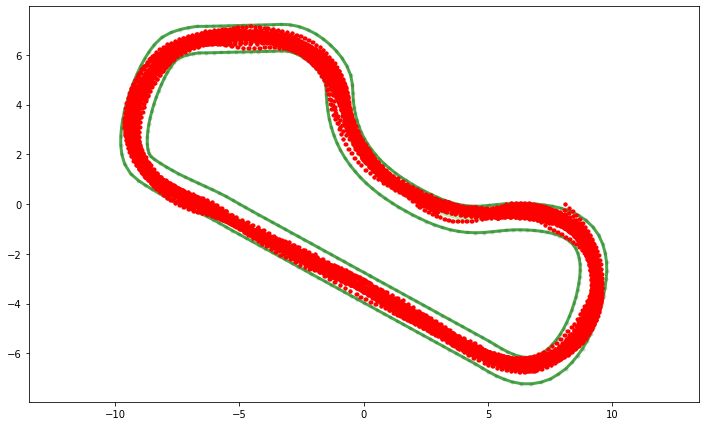

In [14]:
df_complete_episode = pd.DataFrame(columns = ['episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action',
       'reward', 'done', 'all_wheels_on_track', 'progress', 'closest_waypoint',
       'track_len', 'timestamp', 'episode_status', 'pause_duration',
       'iteration'])
df_complete_episode_i = df[df["progress"] == 100]["episode"]

for i in df_complete_episode_i:
    df_i = df[df["episode"]==i]
    #df_complete_episode.append(df_i,ignore_index=True)
    df_complete_episode = pd.concat([df_complete_episode,df_i])

print(f"Total completed laps are:",len(df_complete_episode_i))
plot_episode_complete(df_complete_episode)

## 赛车的视角 View of the model/agent

In [15]:
import cv2
import numpy as np
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [16]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image
import PIL

GRAPH_PB_PATH = 'intermediate_checkpoint/'
models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, ModelUuid))

In [17]:
def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y


In [18]:
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])

In [19]:
model_path = models_file_path[0] #Change this to your model 'pb' frozen graph file

model, obs, model_out = load_session(model_path)
heatmaps = []

#Just need to match up the shape of the neural network
if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    num_of_actions=2
else:
    num_of_actions=len(action_names)

for f in all_files[15:18]:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=num_of_actions)
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_246.pb
Instructions for updating:
Use tf.gfile.GFile.


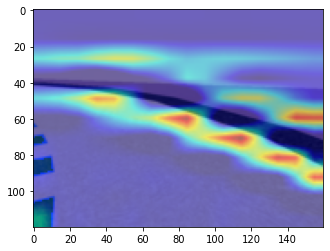

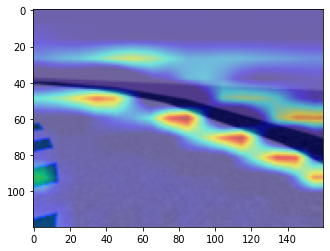

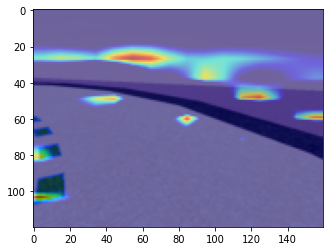

In [20]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()

## 如果赛车经常冲出赛道，可以截图上传，查看赛车视角的热图
- 模型输入的图片是png格式，160*120像素, 色彩空间RGB
- 请将赛车视角的截图上传到 physical_track_img 文件夹下，并更新文件名变量


(120, 160, 3)


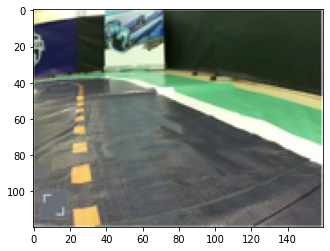

In [21]:
#将图片上传至 physical_track_img 目录下，更新图片名称变量为上传的图片名
image_name = 'image_src.png'

# 加载图片，并对图片进行格式的转换
image_path = 'physical_track_img/'
image = Image.open(image_path + image_name)
image = image.resize((160,120))

#通过截图上传160*120像素大小的图片,转换成RGB 3通道，存储成NP Array，并显示
real_img = np.array(image.convert('RGB'))
print(real_img.shape)
plt.imshow(image)
plt.show()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/f99c83e2-fc9a-4f27-bb4f-94a492b7be2d/model/model_246.pb


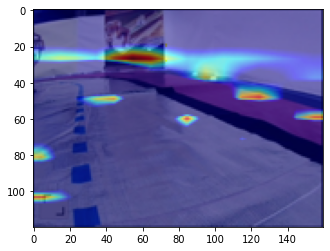

In [22]:
#喂入模型，查看热图
model_path = models_file_path[0] #Change this to your model 'pb' frozen graph file
model, obs, model_out = load_session(model_path)

if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    num_of_actions=2
else:
    num_of_actions=len(action_names)

heatmap = visualize_gradcam_discrete_ppo(model, real_img, category_index=0, num_of_actions=num_of_actions)
tf.reset_default_graph()

plt.imshow(heatmap)
plt.show()